# Visualizing SALSA-CLRS BFS Datasets

This notebook visualizes graphs and BFS (Breadth-First Search) paths from the [SALSA-CLRS](https://github.com/jkminder/SALSA-CLRS) benchmark.

**Data format recap:**
- Each sample is a PyG `CLRSData` object with:
  - `edge_index` — sparse COO edge list `[2, E]`
  - `s` — one-hot source node indicator `[N]`
  - `pi` — BFS predecessor tree as edge-level one-hot mask `[E]` (1.0 where edge is a tree edge)
  - `reach` — reachability mask `[N]` (1.0 if node is reachable from source)
  - `length` — number of BFS algorithmic steps
- Training data additionally has **hints** (`pi_h`, `reach_h`) showing intermediate BFS states per step

In [10]:
import sys
import os

# Add project root to path so we can import from src/
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Import workspace utility
from src.utils.graph_generation import get_bfs_dataset

print(f"Project root: {project_root}")
print(f"PyTorch version: {torch.__version__}")

Project root: /home/marko/projects/gdg/nar-experiments
PyTorch version: 2.10.0+cu128


## 1. Load Datasets

Load validation (ER, n=16), test (all generators × sizes), and training (ER, n=4–16, with hints) splits.

In [11]:
DATA_ROOT = os.path.join(project_root, "data", "salsaclrs")

# Load validation set (ER, n=16, no hints — good for quick visualization)
val_dataset = get_bfs_dataset("val", root=DATA_ROOT)
print(f"Validation set: {len(val_dataset)} samples")

# Load test sets (dict of datasets keyed by generator name)
test_datasets = get_bfs_dataset("test", root=DATA_ROOT)
print(f"\nTest sets ({len(test_datasets)} generators):")
for name, ds in test_datasets.items():
    print(f"  {name}: {len(ds)} samples")

# Load training set (ER, n=4-16, WITH hints for step-by-step visualization)
train_dataset = get_bfs_dataset("train", root=DATA_ROOT)
print(f"\nTraining set: {len(train_dataset)} samples")

Loading BFS dataset for split: val...
Validation set: 1000 samples
Loading BFS dataset for split: test...

Test sets (15 generators):
  er_16: 1000 samples
  er_80: 1000 samples
  er_160: 1000 samples
  er_800: 1000 samples
  er_1600: 1000 samples
  ws_16: 1000 samples
  ws_80: 1000 samples
  ws_160: 1000 samples
  ws_800: 1000 samples
  ws_1600: 1000 samples
  delaunay_16: 1000 samples
  delaunay_80: 1000 samples
  delaunay_160: 1000 samples
  delaunay_800: 1000 samples
  delaunay_1600: 1000 samples
Loading BFS dataset for split: train...

Training set: 10000 samples


In [12]:
# Inspect a single sample from the validation set
sample = val_dataset[0]
print("=== Validation sample (no hints) ===")
print(f"Type: {type(sample).__name__}")
print(f"Keys: {list(sample.keys())}")
print(f"Input fields: {sample.inputs}")
print(f"Output fields: {sample.outputs}")
print(f"Hint fields: {sample.hints if hasattr(sample, 'hints') else 'N/A'}")
print(f"\nedge_index shape: {sample.edge_index.shape}")
print(f"s (source) shape: {sample.s.shape}")
print(f"pos shape: {sample.pos.shape}")
print(f"pi (predecessor) shape: {sample.pi.shape}")
print(f"reach: {'present' if 'reach' in sample.keys() else 'NOT present'}")
print(f"length (BFS steps): {sample.length}")
print(f"\nNumber of nodes: {sample.s.shape[0]}")
print(f"Number of edges (directed): {sample.edge_index.shape[1]}")
print(f"Source node: {sample.s.argmax().item()}")
print(f"BFS tree edges (pi>0.5): {(sample.pi > 0.5).sum().item()}")

print(f"\npi values (first 20): {sample.pi[:20]}")
print(f"pi unique values: {sample.pi.unique()}")

# Also inspect a training sample (with hints)
train_sample = train_dataset[0]
print("\n=== Training sample (with hints) ===")
print(f"Keys: {list(train_sample.keys())}")
print(f"Input fields: {train_sample.inputs}")
print(f"Output fields: {train_sample.outputs}")
print(f"Hint fields: {train_sample.hints}")
print(f"Number of nodes: {train_sample.s.shape[0]}")
print(f"length (BFS steps): {train_sample.length}")
for key in train_sample.keys():
    if hasattr(train_sample[key], 'shape'):
        print(f"  {key}: shape={train_sample[key].shape}, dtype={train_sample[key].dtype}")
    else:
        print(f"  {key}: {train_sample[key]}")

=== Validation sample (no hints) ===
Type: CLRSData
Keys: ['inputs', 'length', 'edge_index', 'pos', 's', 'hints', 'outputs', 'pi']
Input fields: ['pos', 's']
Output fields: ['pi']
Hint fields: []

edge_index shape: torch.Size([2, 70])
s (source) shape: torch.Size([16])
pos shape: torch.Size([16])
pi (predecessor) shape: torch.Size([70])
reach: NOT present
length (BFS steps): 5

Number of nodes: 16
Number of edges (directed): 70
Source node: 10
BFS tree edges (pi>0.5): 16

pi values (first 20): tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=torch.float64)
pi unique values: tensor([0., 1.], dtype=torch.float64)

=== Training sample (with hints) ===
Keys: ['inputs', 'length', 'reach_h', 'edge_index', 'pos', 'pi_h', 's', 'hints', 'outputs', 'pi']
Input fields: ['pos', 's']
Output fields: ['pi']
Hint fields: ['reach_h', 'pi_h']
Number of nodes: 4
length (BFS steps): 4
  inputs: ['pos', 's']
  length: shape=torch.Size([]), dtype=torch.i

## 2. Helper Functions

Utilities to convert SALSA-CLRS `CLRSData` objects to NetworkX graphs and draw them with BFS tree overlays.

In [13]:
def parse_bfs_sample(data):
    """Extract graph structure and BFS results from a CLRSData sample.
    
    Returns:
        G: undirected NetworkX graph
        source: source node index
        bfs_tree_edges: set of (u, v) tuples — directed predecessor edges (child -> parent)
        num_nodes: number of nodes
    """
    edge_index = data.edge_index.numpy()
    num_nodes = data.s.shape[0]
    
    # Build undirected graph
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    edges = set()
    for i in range(edge_index.shape[1]):
        u, v = edge_index[0, i], edge_index[1, i]
        edges.add((min(u, v), max(u, v)))
    G.add_edges_from(edges)
    
    # Source node
    source = data.s.argmax().item()
    
    # BFS tree edges from pi: edges where pi == 1.0
    # pi is [E] — one-hot mask over edge_index
    # edge_index[:, i] = (src, dst) where pi[i] == 1 means dst's predecessor is src
    pi = data.pi.numpy()
    bfs_tree_edges = []
    for i in range(len(pi)):
        if pi[i] > 0.5:
            u, v = edge_index[0, i], edge_index[1, i]
            # Skip self-loops (source points to itself)
            if u != v:
                bfs_tree_edges.append((u, v))
    
    return G, source, bfs_tree_edges, num_nodes


def parse_bfs_hints(data, step):
    """Extract BFS state at a given hint step from a training sample.
    
    Returns:
        reached_nodes: set of node indices reached by step t
        tree_edges: list of (u, v) predecessor edges active at step t
    """
    edge_index = data.edge_index.numpy()
    
    # reach_h: [N, T] — node reachability at each step
    reach = data.reach_h[:, step].numpy()
    reached_nodes = set(np.where(reach > 0.5)[0])
    
    # pi_h: [E, T] — predecessor tree edges at each step  
    pi = data.pi_h[:, step].numpy()
    tree_edges = []
    for i in range(len(pi)):
        if pi[i] > 0.5:
            u, v = edge_index[0, i], edge_index[1, i]
            if u != v:
                tree_edges.append((u, v))
    
    return reached_nodes, tree_edges


def draw_bfs_graph(data, ax=None, title=None, layout="spring", seed=42):
    """Visualize a SALSA-CLRS BFS sample showing the graph and BFS tree.
    
    Args:
        data: CLRSData sample
        ax: matplotlib axes (created if None)
        title: optional title string
        layout: 'kamada_kawai', 'spring', or 'spectral'
        seed: random seed for spring layout
    """
    G, source, bfs_tree_edges, num_nodes = parse_bfs_sample(data)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Layout
    if layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)
    elif layout == "spring":
        pos = nx.spring_layout(G, seed=seed, k=2.0/np.sqrt(num_nodes))
    else:
        pos = nx.spectral_layout(G)
    
    # Draw all edges (light gray)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color="#d0d0d0", width=1.0, alpha=0.8)
    
    # Draw BFS tree edges as directed arrows (child → parent via predecessor)
    if bfs_tree_edges:
        tree_G = nx.DiGraph()
        tree_G.add_nodes_from(G.nodes())
        tree_G.add_edges_from(bfs_tree_edges)  # (src, dst) = predecessor edges
        nx.draw_networkx_edges(
            tree_G, pos, edgelist=bfs_tree_edges, ax=ax,
            edge_color="#e63946", width=2.5, alpha=0.9,
            arrows=True, arrowstyle='-|>', arrowsize=15,
            connectionstyle='arc3,rad=0.1', min_source_margin=10, min_target_margin=10
        )
    
    # Determine which nodes are in the BFS tree
    tree_nodes = set()
    tree_nodes.add(source)
    for u, v in bfs_tree_edges:
        tree_nodes.add(u)
        tree_nodes.add(v)
    
    unreachable = [n for n in G.nodes() if n not in tree_nodes]
    reachable = [n for n in G.nodes() if n in tree_nodes and n != source]
    
    # Draw unreachable nodes
    if unreachable:
        nx.draw_networkx_nodes(G, pos, nodelist=unreachable, ax=ax,
                               node_color="#bbb", node_size=300, edgecolors="#888", linewidths=1.0)
    
    # Draw reachable nodes
    if reachable:
        nx.draw_networkx_nodes(G, pos, nodelist=reachable, ax=ax,
                               node_color="#457b9d", node_size=300, edgecolors="#1d3557", linewidths=1.5)
    
    # Draw source node (larger, distinct color)
    nx.draw_networkx_nodes(G, pos, nodelist=[source], ax=ax,
                           node_color="#f4a261", node_size=500, edgecolors="#e76f51", 
                           linewidths=2.5, node_shape="*")
    
    # Node labels
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=7, font_color="white", font_weight="bold")
    
    # Legend
    legend_elements = [
        Line2D([0], [0], marker='*', color='w', markerfacecolor='#f4a261', 
               markeredgecolor='#e76f51', markersize=15, label='Source'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#457b9d',
               markeredgecolor='#1d3557', markersize=10, label='Reachable'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#bbb',
               markeredgecolor='#888', markersize=10, label='Unreachable'),
        Line2D([0], [0], color='#e63946', linewidth=2.5, label='BFS tree edge (\u2192 parent)'),
        Line2D([0], [0], color='#d0d0d0', linewidth=1.0, label='Graph edge'),
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=7, framealpha=0.9)
    
    # Title
    if title is None:
        title = f"N={num_nodes}, E={G.number_of_edges()}, src={source}, steps={data.length}"
    ax.set_title(title, fontsize=10)
    ax.axis('off')
    
    return pos  # return layout for reuse


print("Helper functions defined.")

Helper functions defined.


## 3. Single Sample Visualization

Visualize one BFS sample from the validation set (Erdős–Rényi, n=16).

Nodes: 16
Undirected edges: 46
Source node: 10
BFS tree edges: 15
BFS steps (length): 4
Graph density: 0.383
Connected: True


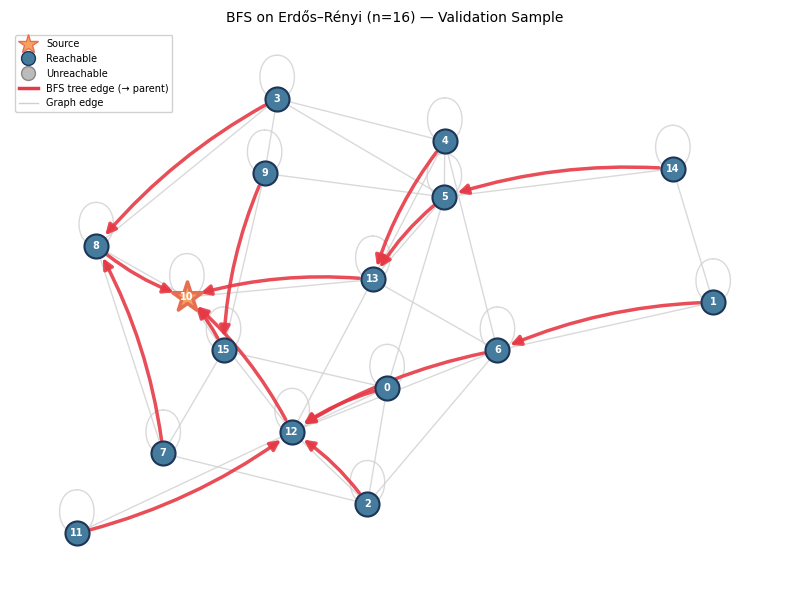

In [14]:
# Visualize a single validation sample
sample = val_dataset[5]  # pick sample index 5
G, source, bfs_tree_edges, num_nodes = parse_bfs_sample(sample)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
draw_bfs_graph(sample, ax=ax, title=f"BFS on Erdős–Rényi (n={num_nodes}) — Validation Sample")

# Print summary statistics
print(f"Nodes: {num_nodes}")
print(f"Undirected edges: {G.number_of_edges()}")
print(f"Source node: {source}")
print(f"BFS tree edges: {len(bfs_tree_edges)}")
print(f"BFS steps (length): {sample.length}")
print(f"Graph density: {nx.density(G):.3f}")
print(f"Connected: {nx.is_connected(G)}")
plt.tight_layout()
plt.show()

## 4. Grid of Random Samples

A 3×3 grid of random validation samples showing diversity in ER graph structure and BFS trees.

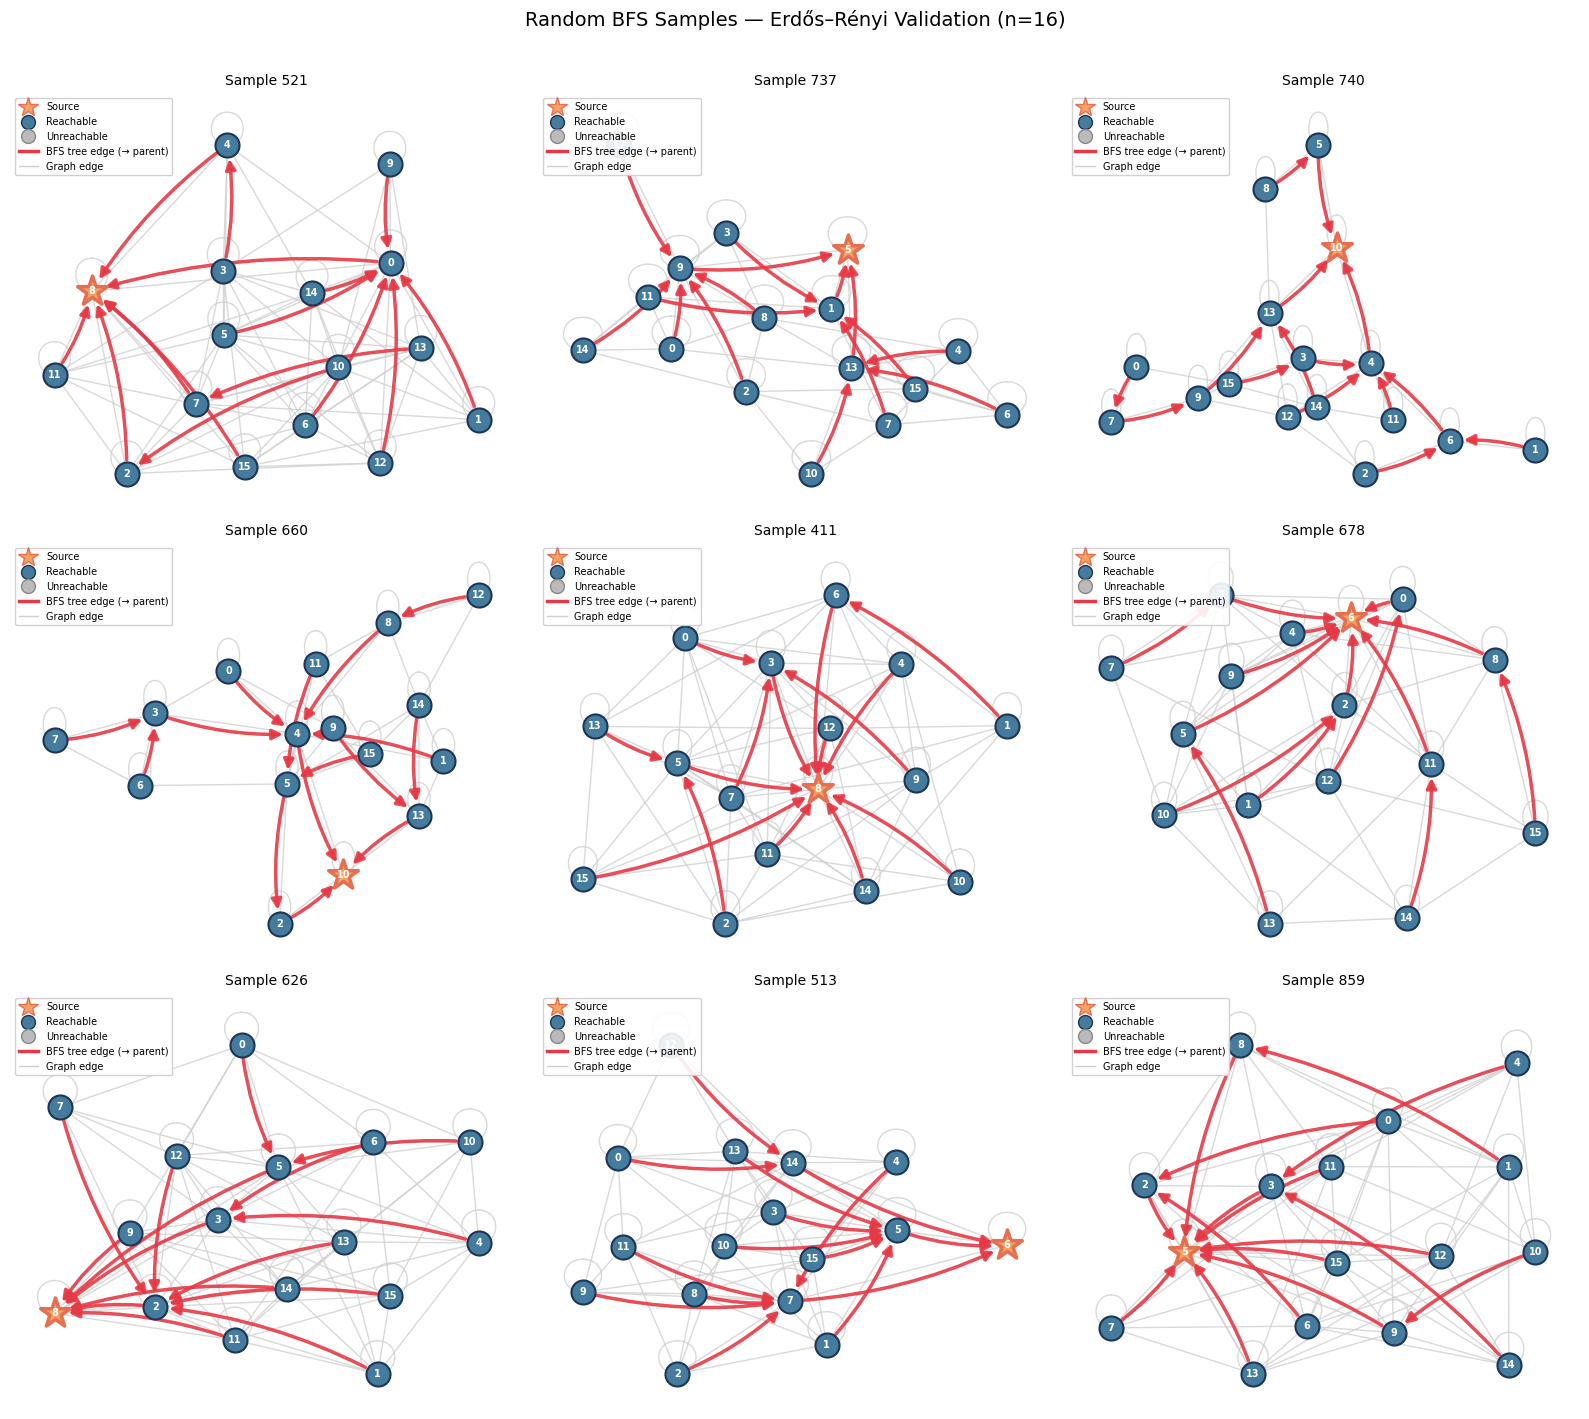

In [15]:
# Grid of 3x3 random validation samples
rng = np.random.RandomState(42)
indices = rng.choice(len(val_dataset), size=9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(16, 14))
for idx, ax in zip(indices, axes.flat):
    sample = val_dataset[idx]
    draw_bfs_graph(sample, ax=ax, title=f"Sample {idx}")

fig.suptitle("Random BFS Samples — Erdős–Rényi Validation (n=16)", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 5. Cross-Generator Comparison

Compare BFS on three different graph generators (Erdős–Rényi, Watts–Strogatz, Delaunay) at n=16, showing structural differences.

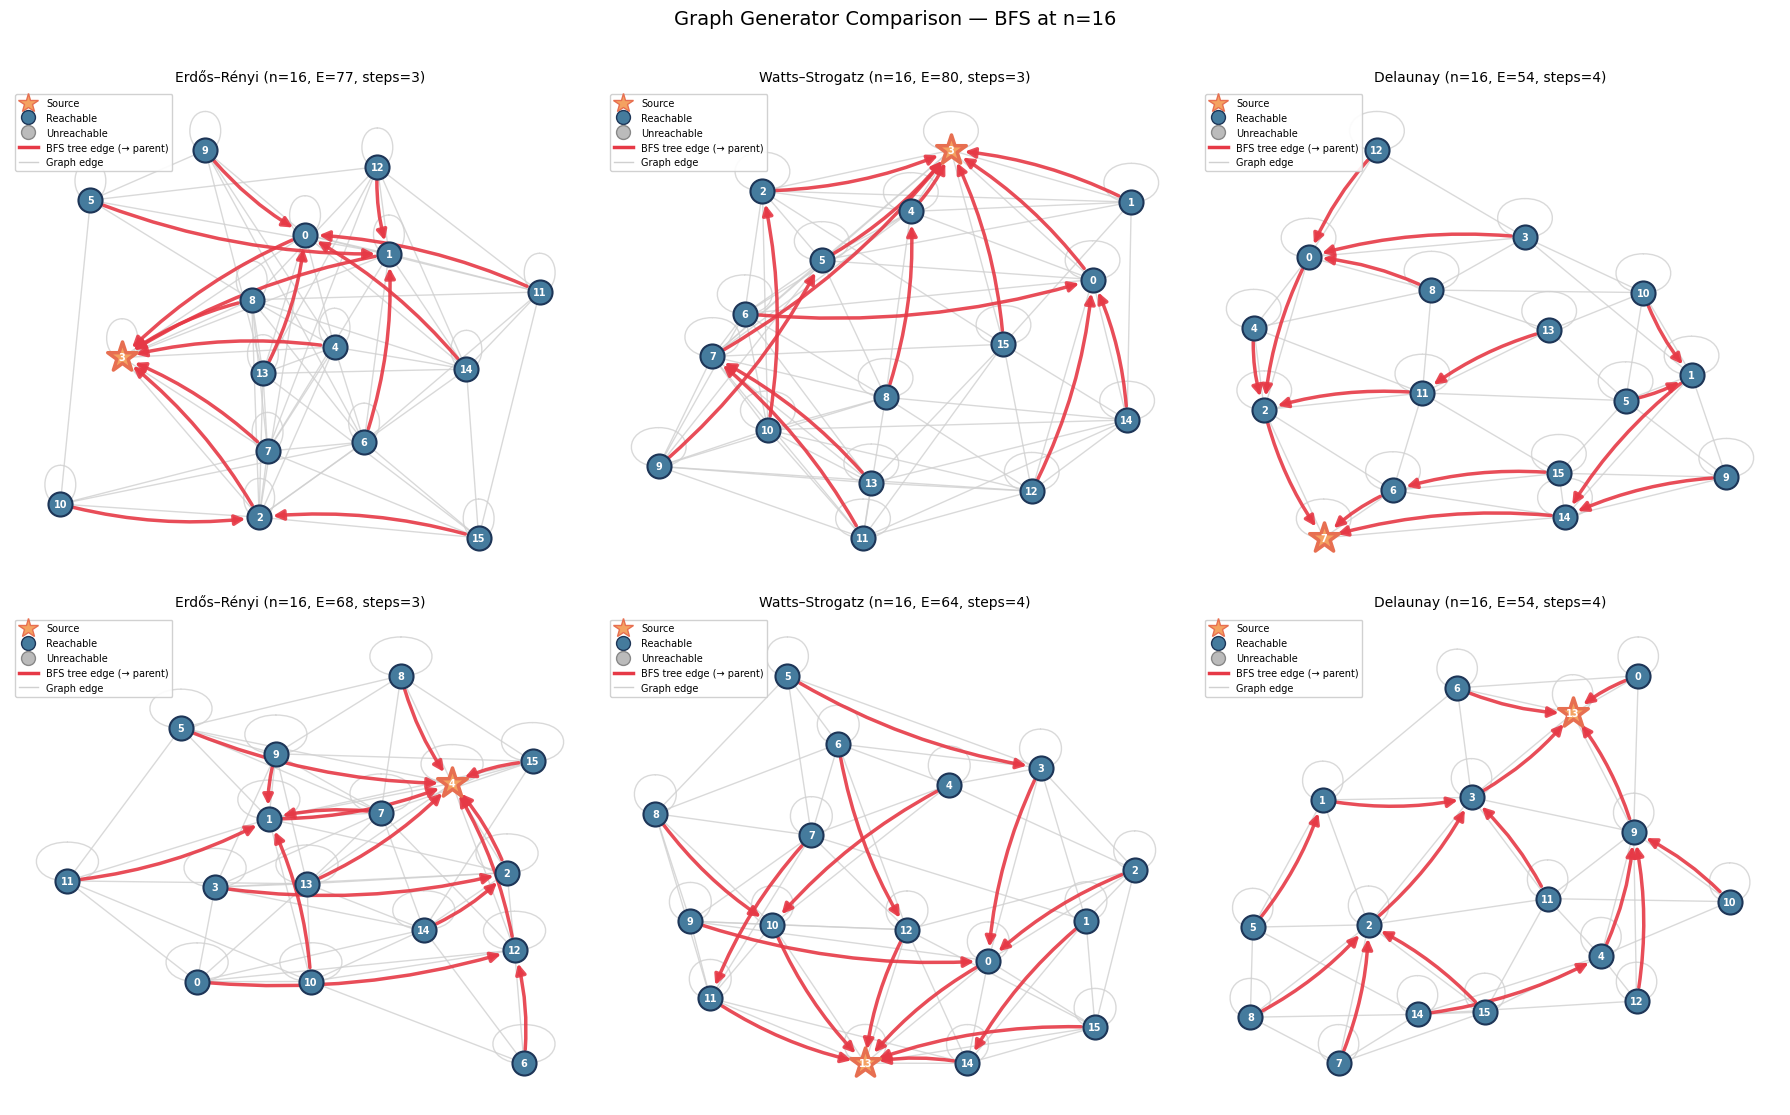

In [16]:
# Compare graph generators at n=16
generators_16 = {
    "Erdős–Rényi": test_datasets["er_16"],
    "Watts–Strogatz": test_datasets["ws_16"],
    "Delaunay": test_datasets["delaunay_16"],
}

fig, axes = plt.subplots(2, 3, figsize=(18, 11))

for col, (gen_name, ds) in enumerate(generators_16.items()):
    for row in range(2):
        sample_idx = row * 7 + 3  # pick different samples per row
        sample = ds[sample_idx]
        G, source, tree_edges, n = parse_bfs_sample(sample)
        ax = axes[row, col]
        draw_bfs_graph(sample, ax=ax,
                       title=f"{gen_name} (n={n}, E={G.number_of_edges()}, steps={sample.length})")

fig.suptitle("Graph Generator Comparison — BFS at n=16", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 6. BFS Step-by-Step (Hint Trace)

The training set includes **hints** — intermediate BFS states at each algorithmic step. This shows the BFS frontier expanding from the source node, with newly reached nodes and tree edges highlighted at each step.

Using training sample 1: N=11, steps=4


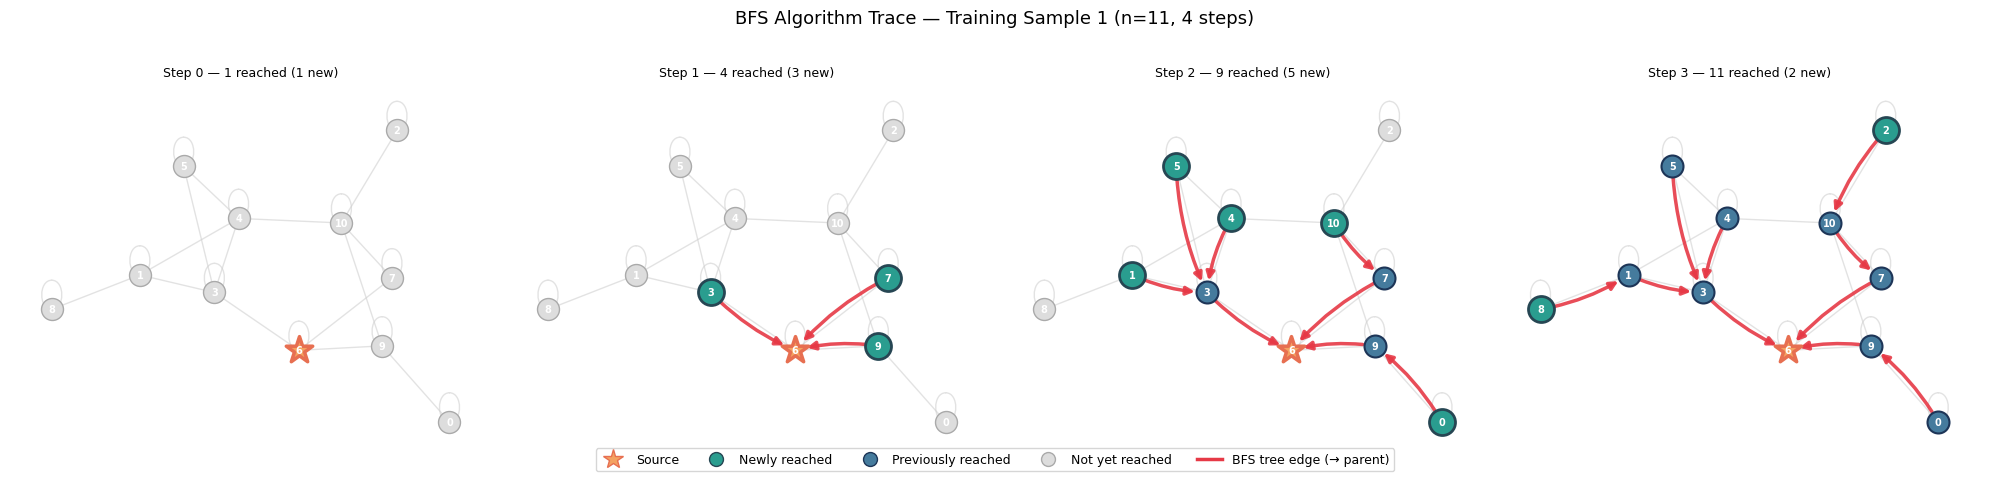

In [19]:
# Find a training sample with a nice number of nodes (e.g. 11-16) and moderate steps
for i in range(len(train_dataset)):
    data = train_dataset[i]
    n = data.s.shape[0]
    steps = data.length.item() if data.length.dim() == 0 else data.length
    if n >= 11 and steps >= 4:
        print(f"Using training sample {i}: N={n}, steps={steps}")
        train_viz_sample = data
        train_viz_idx = i
        break

# Compute fixed layout for all frames
G, source, bfs_tree_edges, num_nodes = parse_bfs_sample(train_viz_sample)
pos = nx.kamada_kawai_layout(G)
T = train_viz_sample.length.item()

# Plot BFS step-by-step
cols = min(T, 4)
rows = (T + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows))
if rows * cols == 1:
    axes = np.array([axes])
axes = axes.flat

edge_index = train_viz_sample.edge_index.numpy()

for t in range(T):
    ax = axes[t]
    reached, tree_edges_t = parse_bfs_hints(train_viz_sample, t)
    
    # Determine newly reached nodes (compared to previous step)
    if t > 0:
        prev_reached, _ = parse_bfs_hints(train_viz_sample, t - 1)
        newly_reached = reached - prev_reached
    else:
        newly_reached = reached
    
    # Draw all edges (light gray)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color="#d0d0d0", width=1.0, alpha=0.6)
    
    # Draw current tree edges as directed arrows
    if tree_edges_t:
        tree_G = nx.DiGraph()
        tree_G.add_nodes_from(G.nodes())
        tree_G.add_edges_from(tree_edges_t)
        nx.draw_networkx_edges(
            tree_G, pos, edgelist=tree_edges_t, ax=ax,
            edge_color="#e63946", width=2.5, alpha=0.9,
            arrows=True, arrowstyle='-|>', arrowsize=12,
            connectionstyle='arc3,rad=0.1', min_source_margin=8, min_target_margin=8
        )
    
    # Classify nodes
    unreached = [n for n in G.nodes() if n not in reached]
    old_reached = [n for n in reached if n not in newly_reached and n != source]
    new_reached = [n for n in newly_reached if n != source]
    
    # Draw unreached nodes
    if unreached:
        nx.draw_networkx_nodes(G, pos, nodelist=unreached, ax=ax,
                               node_color="#ddd", node_size=250, edgecolors="#aaa", linewidths=1.0)
    # Draw previously reached
    if old_reached:
        nx.draw_networkx_nodes(G, pos, nodelist=old_reached, ax=ax,
                               node_color="#457b9d", node_size=250, edgecolors="#1d3557", linewidths=1.5)
    # Draw newly reached (highlighted)
    if new_reached:
        nx.draw_networkx_nodes(G, pos, nodelist=new_reached, ax=ax,
                               node_color="#2a9d8f", node_size=350, edgecolors="#264653", linewidths=2.0)
    # Source
    nx.draw_networkx_nodes(G, pos, nodelist=[source], ax=ax,
                           node_color="#f4a261", node_size=400, edgecolors="#e76f51", 
                           linewidths=2.5, node_shape="*")
    
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=7, font_color="white", font_weight="bold")
    
    ax.set_title(f"Step {t} — {len(reached)} reached ({len(newly_reached)} new)", fontsize=9)
    ax.axis('off')

# Hide unused subplot axes
for j in range(T, rows * cols):
    axes[j].set_visible(False)

# Legend
legend_elements = [
    Line2D([0], [0], marker='*', color='w', markerfacecolor='#f4a261', 
           markeredgecolor='#e76f51', markersize=15, label='Source'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2a9d8f',
           markeredgecolor='#264653', markersize=10, label='Newly reached'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#457b9d',
           markeredgecolor='#1d3557', markersize=10, label='Previously reached'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#ddd',
           markeredgecolor='#aaa', markersize=10, label='Not yet reached'),
    Line2D([0], [0], color='#e63946', linewidth=2.5, label='BFS tree edge (\u2192 parent)'),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=9, 
           bbox_to_anchor=(0.5, -0.02))

fig.suptitle(f"BFS Algorithm Trace — Training Sample {train_viz_idx} (n={num_nodes}, {T} steps)", 
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 7. Size Scaling — n=16 vs n=80

How graph structure and BFS trees change with increasing graph size. Larger graphs have sparser relative connectivity and deeper BFS trees.

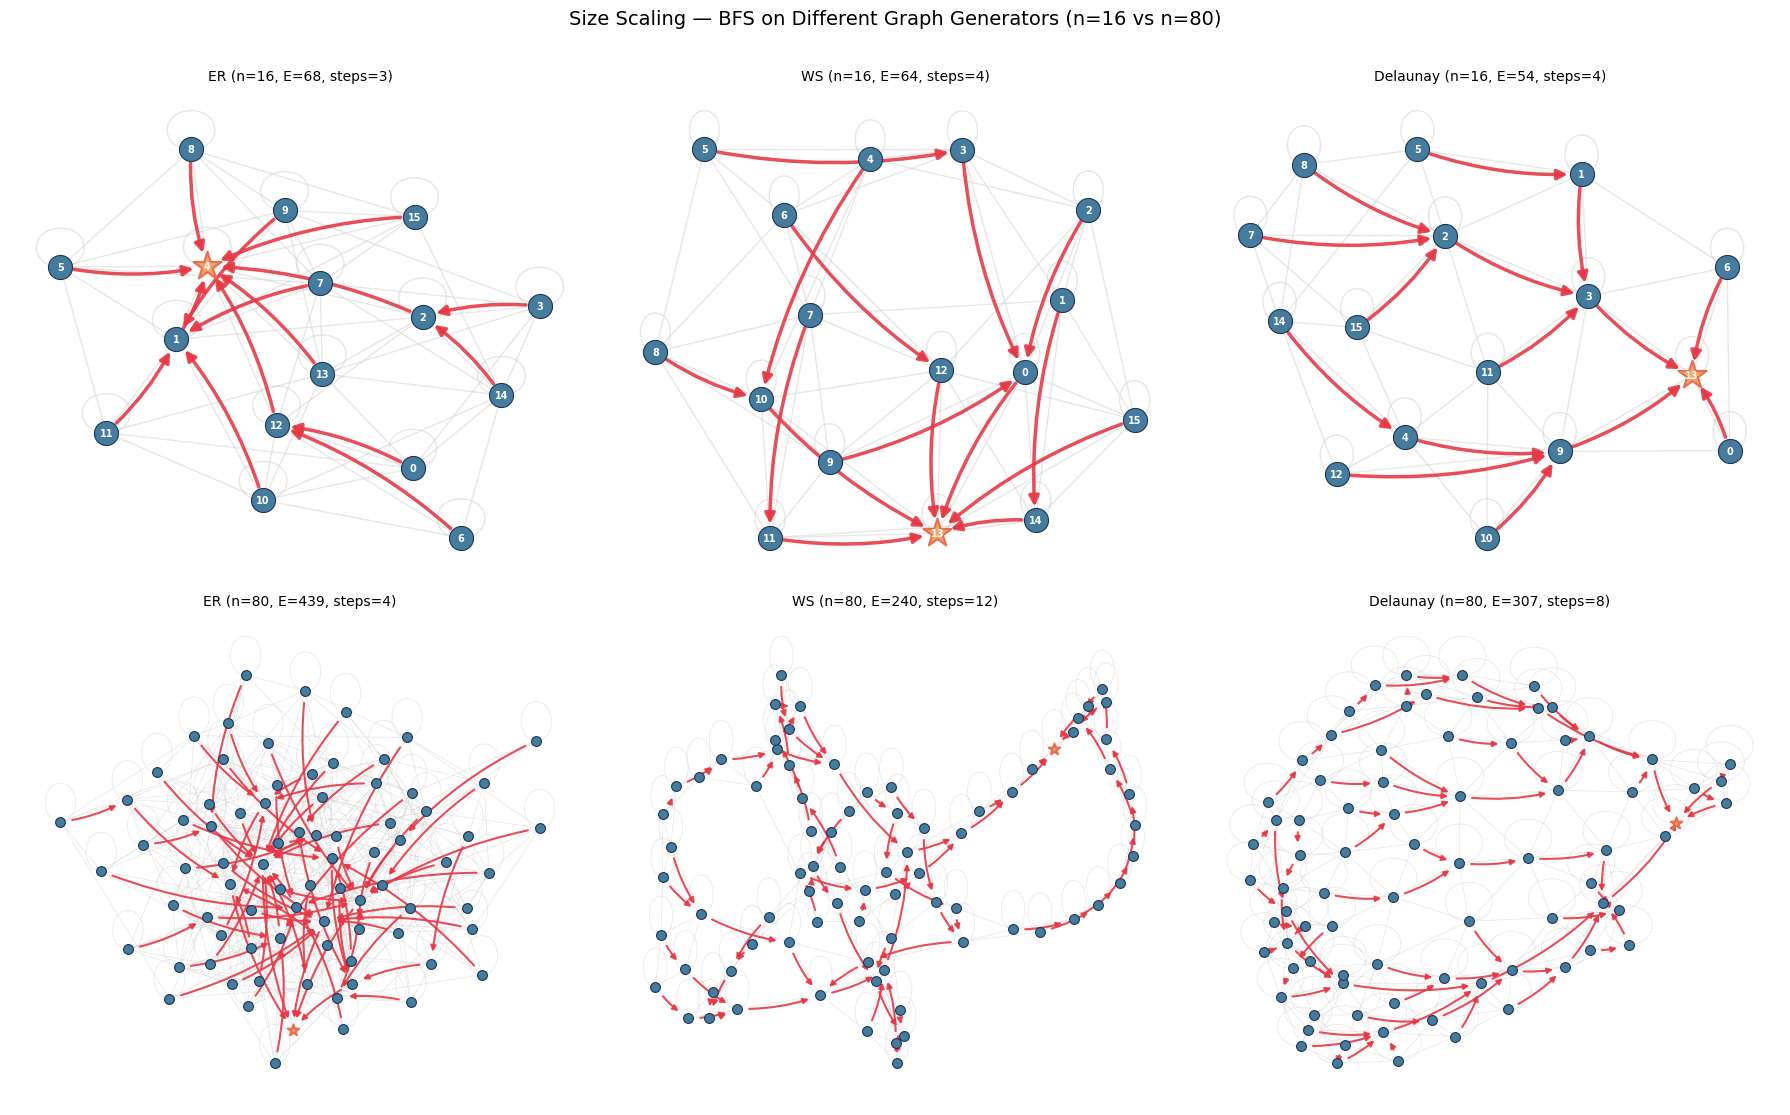

In [21]:
# Size scaling: ER at n=16 and n=80 for each generator type
sizes_to_show = {
    "ER n=16": test_datasets["er_16"],
    "ER n=80": test_datasets["er_80"],
    "WS n=16": test_datasets["ws_16"],
    "WS n=80": test_datasets["ws_80"],
    "Delaunay n=16": test_datasets["delaunay_16"],
    "Delaunay n=80": test_datasets["delaunay_80"],
}

fig, axes = plt.subplots(2, 3, figsize=(18, 11))
sample_idx = 10

for col, gen in enumerate(["ER", "WS", "Delaunay"]):
    for row, size in enumerate([16, 80]):
        key = f"{gen} n={size}"
        ds = sizes_to_show[key]
        sample = ds[sample_idx]
        G, source, tree_edges, n = parse_bfs_sample(sample)
        ax = axes[row, col]
        
        # Use spring layout for larger graphs (kamada_kawai is slow for n=80)
        layout = "kamada_kawai" if size <= 16 else "spring"
        node_size = 300 if size <= 16 else 50
        font_size = 7 if size <= 16 else 0  # skip labels for n=80
        
        # Draw base graph
        pos_layout = nx.kamada_kawai_layout(G) if size <= 16 else nx.spring_layout(G, seed=42, k=1.5/np.sqrt(n))
        
        # All edges
        nx.draw_networkx_edges(G, pos_layout, ax=ax, edge_color="#d0d0d0", width=0.5 if size > 16 else 1.0, alpha=0.5)
        
        # BFS tree edges as directed arrows
        if tree_edges:
            tree_G = nx.DiGraph()
            tree_G.add_nodes_from(G.nodes())
            tree_G.add_edges_from(tree_edges)
            arrow_size = 8 if size > 16 else 15
            margin = 4 if size > 16 else 10
            nx.draw_networkx_edges(
                tree_G, pos_layout, edgelist=tree_edges, ax=ax,
                edge_color="#e63946", width=1.5 if size > 16 else 2.5, alpha=0.9,
                arrows=True, arrowstyle='-|>', arrowsize=arrow_size,
                connectionstyle='arc3,rad=0.1', min_source_margin=margin, min_target_margin=margin
            )
        
        # Nodes
        tree_nodes = {source}
        for u, v in tree_edges:
            tree_nodes.add(u)
            tree_nodes.add(v)
        
        reachable = [n for n in G.nodes() if n in tree_nodes and n != source]
        unreachable = [n for n in G.nodes() if n not in tree_nodes]
        
        if unreachable:
            nx.draw_networkx_nodes(G, pos_layout, nodelist=unreachable, ax=ax,
                                   node_color="#bbb", node_size=node_size, edgecolors="#888", linewidths=0.5)
        if reachable:
            nx.draw_networkx_nodes(G, pos_layout, nodelist=reachable, ax=ax,
                                   node_color="#457b9d", node_size=node_size, edgecolors="#1d3557", linewidths=0.8)
        nx.draw_networkx_nodes(G, pos_layout, nodelist=[source], ax=ax,
                               node_color="#f4a261", node_size=node_size * 1.5, edgecolors="#e76f51", 
                               linewidths=1.5, node_shape="*")
        
        if font_size > 0:
            nx.draw_networkx_labels(G, pos_layout, ax=ax, font_size=font_size, font_color="white", font_weight="bold")

        ax.set_title(f"{gen} (n={n}, E={G.number_of_edges()}, steps={sample.length})", fontsize=10)
        ax.axis('off')

fig.suptitle("Size Scaling — BFS on Different Graph Generators (n=16 vs n=80)", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()


## 8. Disconnected Graph — Unreachable Nodes

ER graphs are not guaranteed to be connected. Here we find a sample with unreachable nodes and visualize how the BFS tree only spans the source's connected component.

Found suitable disconnected graph on attempt 80
Nodes: 16, Edges: 32
Connected components: 2 (sizes: [9, 7])
Source node 3 is in component of size 9
Unreachable nodes: 7
BFS tree edges: 8


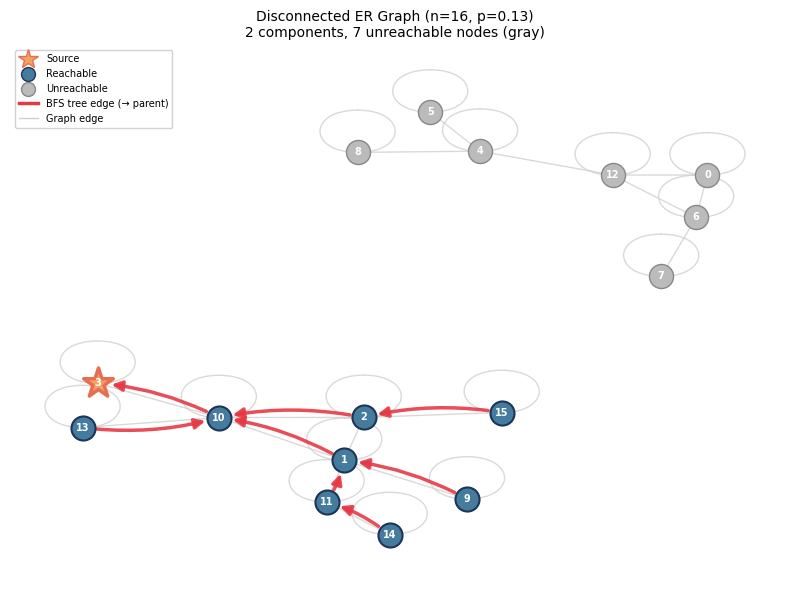

In [43]:
# SALSA-CLRS enforces connected graphs via rejection sampling in _random_er_graph():
#   while True:
#       g = nx.erdos_renyi_graph(n, p)
#       if not nx.is_connected(g): continue   # retry until connected
#       return g
#
# So no dataset sample will ever have unreachable nodes.
# To demonstrate what a disconnected BFS looks like, we generate one manually
# using the SALSA-CLRS pipeline but bypassing the connectivity check.

from salsaclrs.sampler import build_sampler
from salsaclrs.data import to_sparse_data
import math

n_target = 16
p_val = 0.13  # just below connectivity threshold log(16)/16 ≈ 0.17

sampler, specs = build_sampler("bfs", "er", {"n": n_target, "p_range": (p_val, p_val)})

# Monkeypatch the sampler's graph generator to skip the connectivity check
original_er = sampler._random_er_graph

def er_allow_disconnected(n, p=None, p_range=None, **kwargs):
    kwargs['connected'] = False
    return original_er(n, p=p, p_range=p_range, **kwargs)

sampler._random_er_graph = er_allow_disconnected

# Generate until we find a disconnected graph with 2-4 components
# where the source's component has at least 5 nodes (interesting BFS tree)
for attempt in range(5000):
    inp, outp, hints = sampler.next()
    data = to_sparse_data(inp, hints, outp, use_hints=False)
    G_check, src, _, _ = parse_bfs_sample(data)
    if not nx.is_connected(G_check):
        components = list(nx.connected_components(G_check))
        src_comp = [c for c in components if src in c][0]
        if 2 <= len(components) <= 4 and len(src_comp) >= 5 and min([len(comp) for comp in components]) >=4:
            print(f"Found suitable disconnected graph on attempt {attempt + 1}")
            break

G, source, bfs_tree_edges, num_nodes = parse_bfs_sample(data)
components = list(nx.connected_components(G))
source_component = [c for c in components if source in c][0]

print(f"Nodes: {num_nodes}, Edges: {G.number_of_edges()}")
print(f"Connected components: {len(components)} "
      f"(sizes: {sorted([len(c) for c in components], reverse=True)})")
print(f"Source node {source} is in component of size {len(source_component)}")
print(f"Unreachable nodes: {num_nodes - len(source_component)}")
print(f"BFS tree edges: {len(bfs_tree_edges)}")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
draw_bfs_graph(data, ax=ax,
               title=f"Disconnected ER Graph (n={num_nodes}, p={p_val})\n"
                     f"{len(components)} components, "
                     f"{num_nodes - len(source_component)} unreachable nodes (gray)")
plt.tight_layout()
plt.show()